In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import calendar
plt.style.use('ggplot')
import seaborn as sns
import datetime
pd.set_option('display.max_columns', 500)
from scipy.stats import ttest_ind,boxcox,chi2_contingency
import os, pickle
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from state_abbr import states as states_dict

FIG_SIZE = (15,5)

### Load data

In [2]:
data_size = 'large' # ['small','medium','large']
flights = pd.read_csv("flights_{0}.csv".format(data_size)) 
flights["Date"] = pd.to_datetime(flights["Date"]) # format date
any_nans = flights.isnull().values.any()
n,m = flights.shape
print("n observations = {0:,}. n features = {1}. Any NANs = {2}".format(n,m,any_nans))

n observations = 10,000,000. n features = 19. Any NANs = True


In [3]:
flights

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2010-12-27,HA,19690,SAN,CA,HNL,HI,1311,1,2047,12,2035.0,1310.0,-157.92,21.31,-157.92,21.31,HI to CA,1
1,2004-04-10,HA,19690,SAN,CA,HNL,HI,1336,11,2146,11,2135.0,1325.0,-157.92,21.31,-157.92,21.31,HI to CA,1
2,2004-04-29,HA,19690,SAN,CA,HNL,HI,1404,39,2223,48,2135.0,1325.0,-157.92,21.31,-157.92,21.31,HI to CA,1
3,2008-09-09,HA,19690,SAN,CA,HNL,HI,1333,-2,2147,-3,2150.0,1335.0,-157.92,21.31,-157.92,21.31,HI to CA,1
4,2011-03-30,HA,19690,SAN,CA,HNL,HI,1314,-1,2158,23,2135.0,1315.0,-157.92,21.31,-157.92,21.31,HI to CA,1
5,2011-03-24,HA,19690,SAN,CA,HNL,HI,1314,-1,2140,5,2135.0,1315.0,-157.92,21.31,-157.92,21.31,HI to CA,1
6,2008-12-29,HA,19690,SAN,CA,HNL,HI,1416,6,2131,1,2130.0,1410.0,-157.92,21.31,-157.92,21.31,HI to CA,1
7,2012-01-29,HA,19690,SAN,CA,HNL,HI,1501,111,2238,123,2035.0,1310.0,-157.92,21.31,-157.92,21.31,HI to CA,1
8,2011-06-15,HA,19690,SAN,CA,HNL,HI,1303,3,2133,3,2130.0,1300.0,-157.92,21.31,-157.92,21.31,HI to CA,1
9,2012-05-29,HA,19690,SAN,CA,HNL,HI,1345,0,2212,2,2210.0,1345.0,-157.92,21.31,-157.92,21.31,HI to CA,1


Get year, month of flight and add full departure state name

In [4]:
flights.insert(loc=1,column="month",value=pd.DatetimeIndex(flights['Date']).month)
flights.insert(loc=1,column="year",value=pd.DatetimeIndex(flights['Date']).year)
flights['Departure_State_Full'] = flights.Departure_State.apply(lambda state: states_dict[state])
flights[["Date","year","month",'Departure_State_Full','Departure_State']].sample(5)

,Date,year,month,Departure_State_Full,Departure_State
680152,2003-09-04,2003,9,Alaska,AK
6156295,2007-08-17,2007,8,Massachusetts,MA
2910744,2003-07-28,2003,7,Florida,FL
7397429,2003-12-24,2003,12,Colorado,CO
3879012,2008-12-10,2008,12,Montana,MT


### What is the trend over time in number of flights?

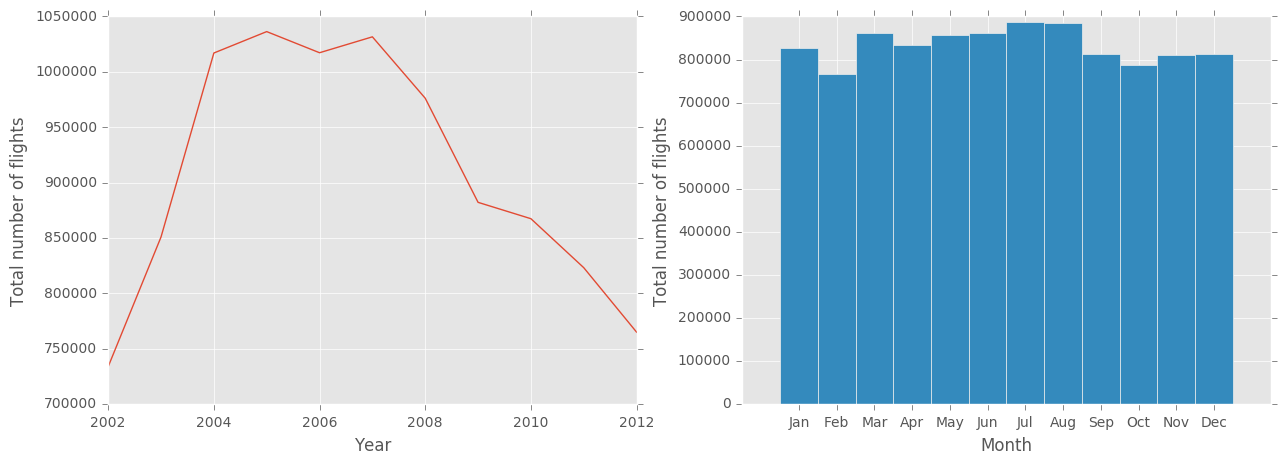

In [5]:
flights_by_year = flights.groupby('year').size()
flights_by_month = flights.groupby('month').size()
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
months = flights_by_month.index 
months_names = [calendar.month_abbr[mon] for mon in months]
width=1.0
ax1.plot(flights_by_year); ax1.set_xlabel("Year"); ax1.set_ylabel("Total number of flights")
ax2.bar(months,flights_by_month,width=width); ax2.set_xticklabels(months_names); ax2.set_xticks(months + width / 2);
ax2.set_xlabel("Month"); ax2.set_ylabel("Total number of flights")
plt.show()

* Flights by year shows decrease in total annual flights after 2006. Possibly due to financial crash.
* Flights by month differences might possibly be related to US holidays.

### Departure traffic by state

In [6]:
state_dep_counts = pd.DataFrame(flights["Departure_State"].value_counts())
data = [ dict(type='choropleth',  autocolorscale = True, #colorscale = scl,
        locations = state_dep_counts.index,
        z = state_dep_counts['Departure_State'].astype(float),
        locationmode = 'USA-states',
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "Departure total traffic")
    ) ]

layout = dict(title = 'Departure total traffic',
        geo = dict(scope='usa',projection=dict( type='albers usa' ),showlakes = True,lakecolor = 'rgb(255, 255, 255)'),
    )
fig = dict( data=data, layout=layout )
iplot(data)  

# <center>Delay times - exploratory.</center>

[Top reasons for delays](http://www.mro-network.com/maintenance-repair-overhaul/top-5-reasons-flight-delays/gallery?slide=5)
* late arriving aircraft - can't obtain this feature as we don't have a unique plane id in dataset.
* air carrier delays - no info
* heavy traffic volume - can model this
* extreme weather - can model this
* security lines - no info.

### Delays are highly skewed (focus on departure delays as opposed to arrivals)

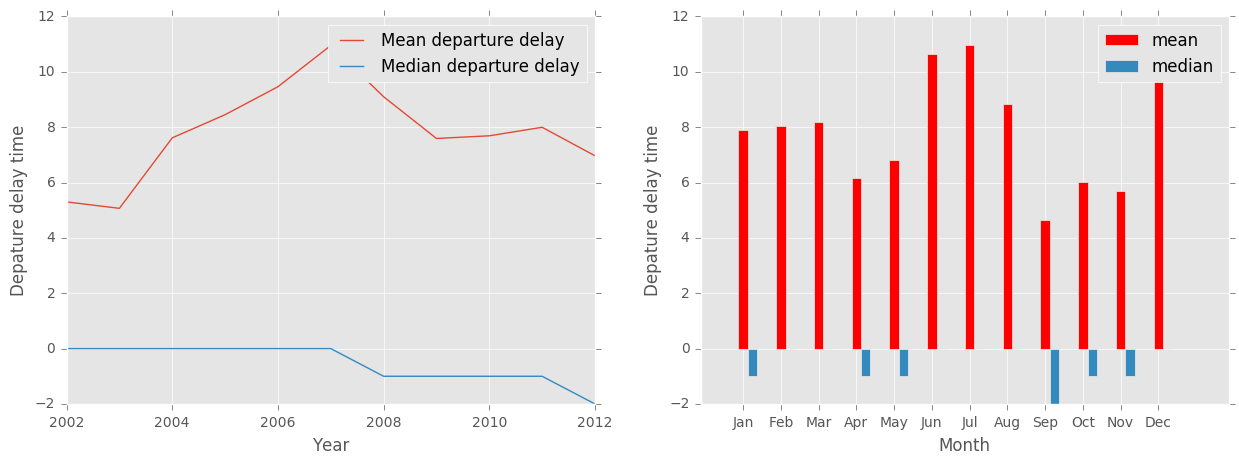

In [7]:
departure_delay_year = flights[["Departure_delay","year"]].groupby("year").agg(["mean","median"]) 
departure_delay_month = flights[["Departure_delay","month"]].groupby('month').agg(["mean","median"])
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
ax1.plot(departure_delay_year)
ax1.legend(("Mean departure delay","Median departure delay"))
ax1.set_ylabel("Depature delay time"); ax1.set_xlabel("Year")

width = 0.25
ax2.bar(months,departure_delay_month["Departure_delay"]["mean"].values,width=width,color='red');
ax2.bar(months+width,departure_delay_month["Departure_delay"]["median"].values,width=width);
ax2.set_xticklabels(months_names); ax2.set_xticks(months + width / 2);
ax2.set_xlabel("Month"); ax2.set_ylabel("Depature delay time")
ax2.legend(("mean","median"))
plt.show()

* Delays seem to be correlated with overall traffic. E.g. delays are more likely to be long in high traffic months such as june, july as well as high traffic years e.g. 2006. 
* Delays also very higher in winter months as expected.
* Mean >> Median implying positivley skewed delays. I.e there are few very long delays

### Let's clip any negative departure delays less than the 1% quantile. These are not really 'delays'.

In [8]:
quantile_lower_clip = np.percentile(flights['Departure_delay'],1)
flights['Departure_delay'] = flights['Departure_delay'].clip_lower(quantile_lower_clip)

# Airline descriptions

In [9]:
def stat_summary(group): # summary statistics for pandas groupby
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
flights['Departure_delay'].groupby(flights['Airline']).apply(stat_summary).unstack()

,count,max,mean,min
Airline,,,,
9E,131534.0,1099.0,7.424118,-12.0
AA,405447.0,1319.0,10.133909,-12.0
AS,316270.0,1140.0,7.609369,-12.0
B6,69347.0,639.0,10.702020,-12.0
CO,165277.0,806.0,8.745494,-12.0
DH,89030.0,465.0,8.532843,-12.0
DL,977202.0,1126.0,6.711711,-12.0
EV,619045.0,1040.0,13.274188,-12.0
F9,178660.0,1014.0,6.018387,-12.0


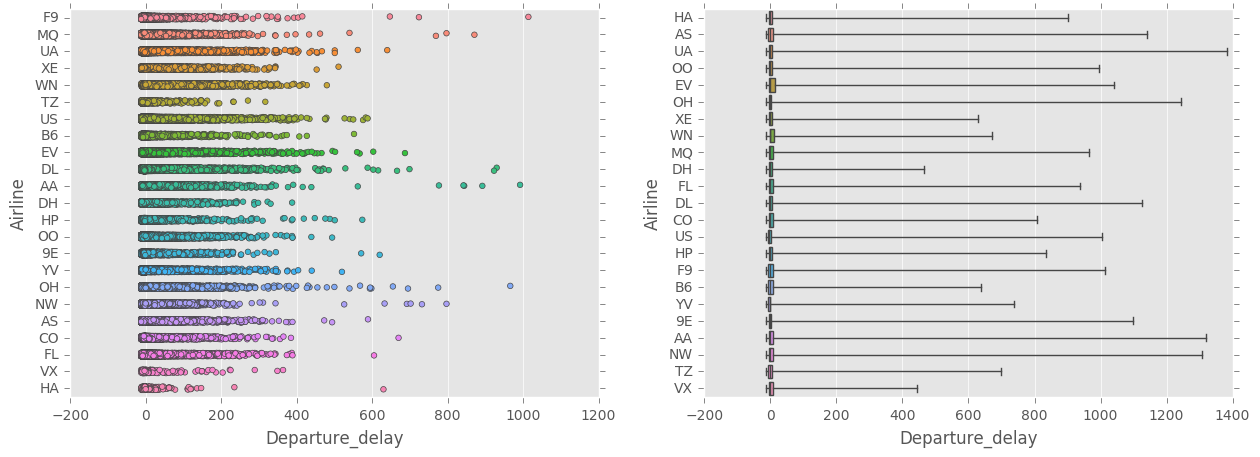

In [10]:
#strip_plot_path = "airline_strip_plot_{0}.png".format(data_size)
f, (ax1,ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sample = flights.sample(frac=0.05) # stripplot takes ages
sns.stripplot(y='Airline', x='Departure_delay', size = 4, data=sample, linewidth = 0.5,  jitter=True, ax=ax1)
sns.boxplot(y='Airline', x='Departure_delay', data=flights, whis=np.inf, ax=ax2)
plt.show()

### Remove positive outliers 

99% quantile = 140.0.


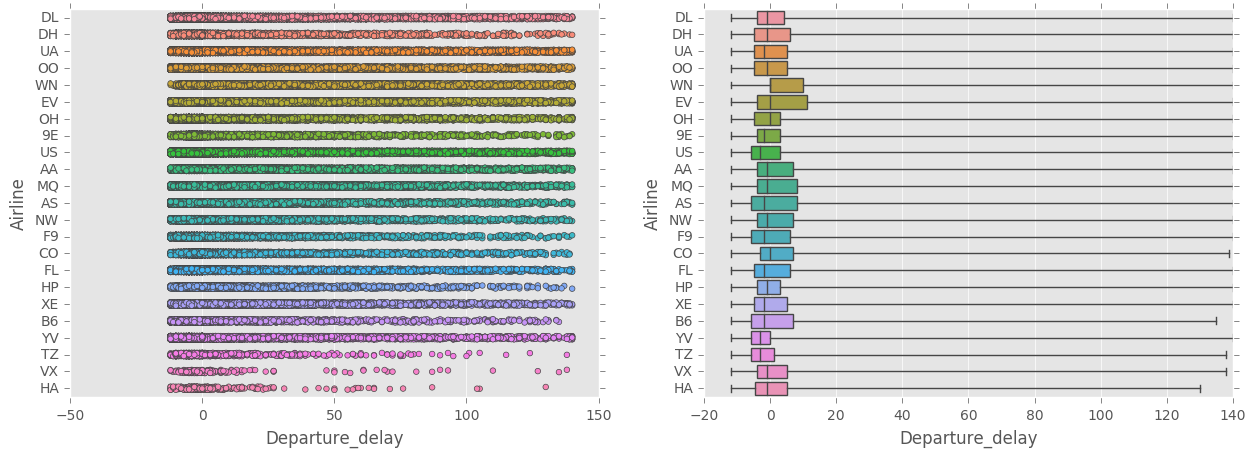

In [11]:
quantile = 99
quantile_upper_remove = np.percentile(flights.Departure_delay,quantile)
print("{0}% quantile = {1}.".format(quantile,quantile_upper_remove))
flights = flights.drop(flights[flights.Departure_delay > quantile_upper_remove].index)
f, (ax1,ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sample = flights.sample(frac=0.05)
sns.stripplot(y='Airline', x='Departure_delay', size = 4, data=sample, linewidth = 0.5,  jitter=True, ax=ax1)
sns.boxplot(y='Airline', x='Departure_delay', data=sample, whis=np.inf, ax=ax2)
plt.show()

###  Bin response variable ```Departure_delay``` into ($-\infty$-10], (10-45], (45-$\infty$)

In [12]:
flights['Departure_delay_bin'] = pd.cut(flights['Departure_delay'],
                                        bins=(quantile_lower_clip-1,5,45,quantile_upper_remove+1),
                                        labels=("No delay","Small delay","Long delay"))
(flights['Departure_delay_bin'].value_counts()/flights.shape[0])

No delay       0.745674
Small delay    0.196446
Long delay     0.057880
Name: Departure_delay_bin, dtype: float64

### Functions to use later on

In [15]:
class Cross_tab(): # cross tabulate two variables and do chi2 test of independence. reject if p value is small i.e. good predictor
    def __init__(self,var1,var2):
        self.cross_tab = pd.crosstab(var1,var2)
        
    def chi2_test(self,alpha=0.01):
        chi2_test = chi2_contingency(self.cross_tab)
        self.pval = chi2_test[1]
        if self.pval < alpha:
            result = 'reject independence'
        else:
            result = 'accept null of independence'
        print(self.cross_tab)
        print(self.cross_tab.div(self.cross_tab.sum(axis=1),axis=0))
        print('\n P value = {0:.6f}. {1}'.format(self.pval,result))

def plot_two_dist(dist1,dist2,title_append=''): # plot function used later
    dist1_n, dist2_n = dist1['values'].size, dist2['values'].size
    f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
    sns.distplot(dist1['values'],ax=ax1,label=dist1['name'],color='red',bins=15)
    sns.distplot(dist2['values'],ax=ax1,label=dist2['name'],color='blue',bins=15)
    ax1.vlines(dist1['values'].mean(), 0, 1,colors='red',linestyles='dashdot')
    ax1.vlines(dist2['values'].mean(), 0, 1,colors='blue',linestyles='dashdot')
    plt.title("Counts for {0}={1}, {2}={3}. {4}".format(dist1['name'],dist1_n,
                                                   dist2['name'],dist2_n,
                                                     title_append))
    plt.legend()
    plt.show()

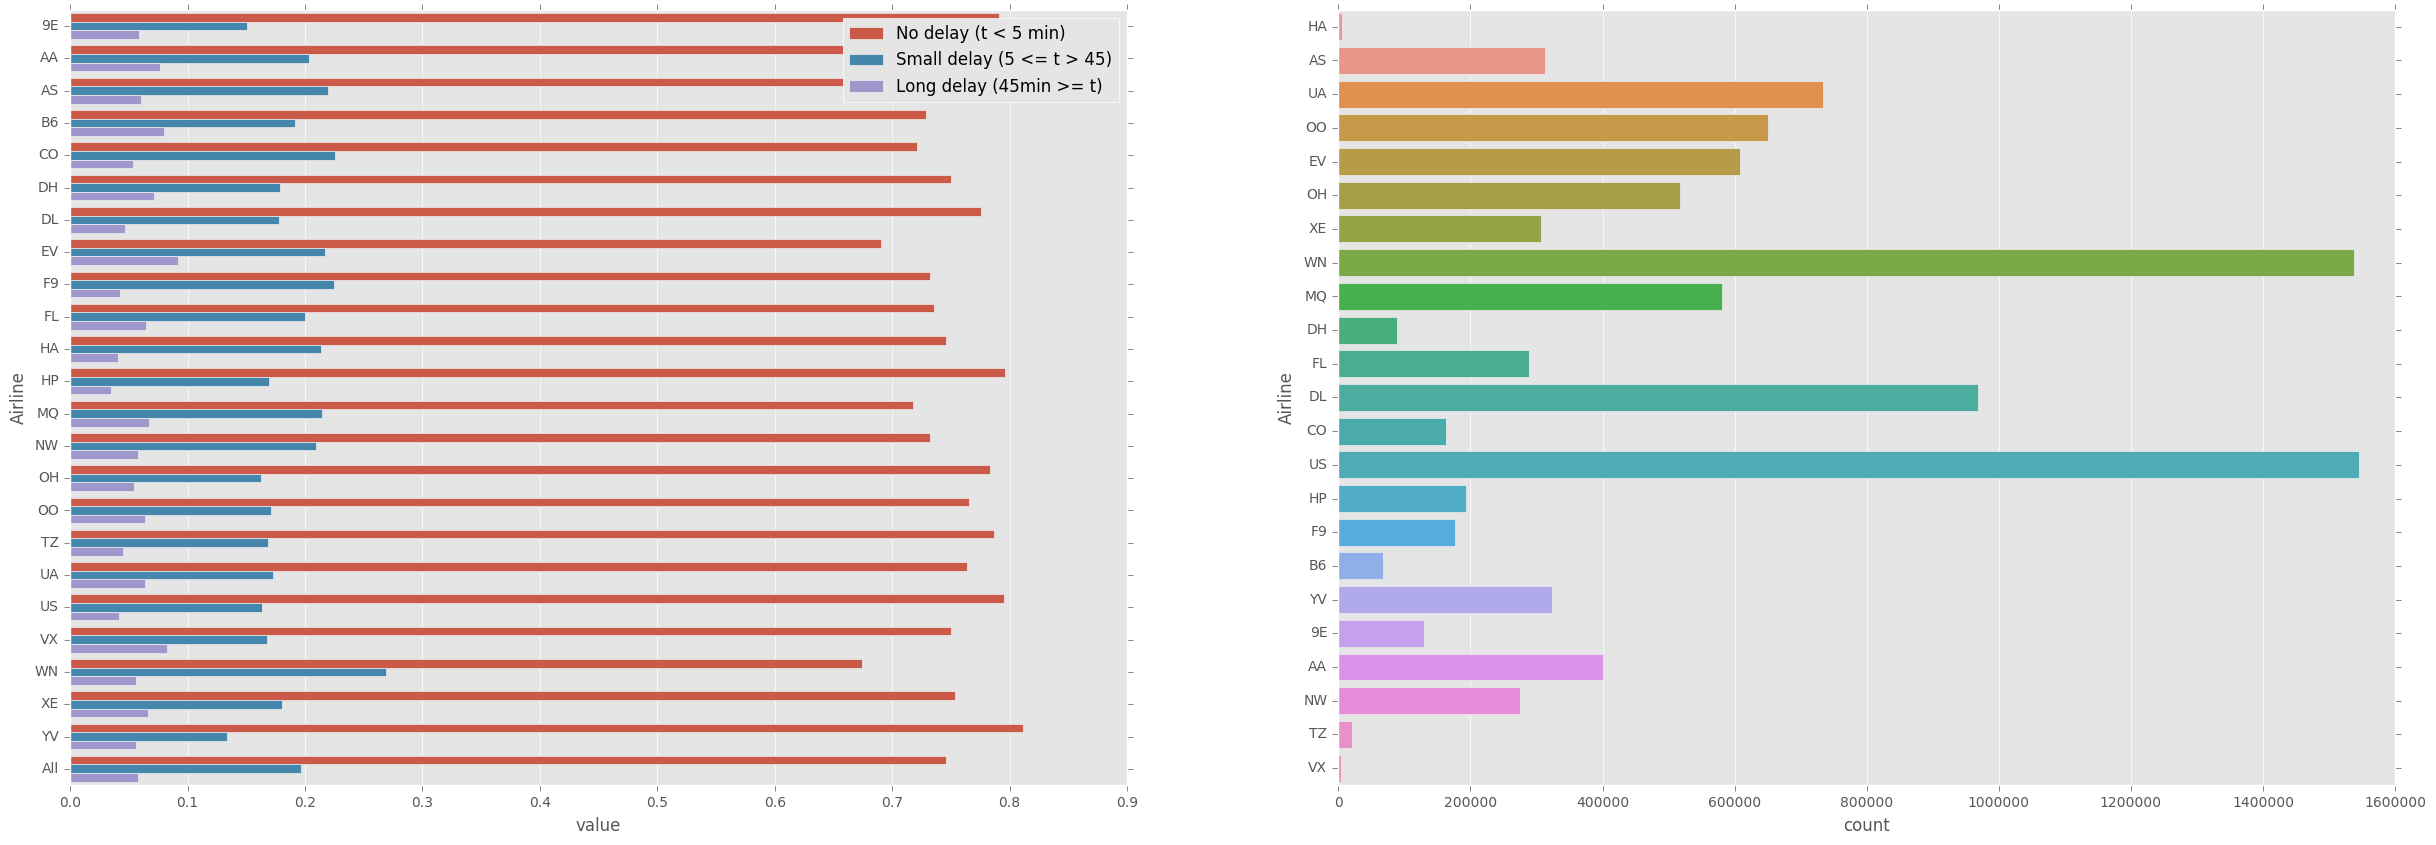

In [16]:
delays_airline = pd.crosstab(flights['Airline'],flights['Departure_delay_bin'],margins=True)
delays_airline = delays_airline[delays_airline.All>1000] # consider states who have had at least 1000 flights
delays_airline.drop('All',axis=1,inplace=True)
delays_airline_prop = delays_airline.div(delays_airline.sum(axis=1), axis=0)
delays_airline_prop_stack = delays_airline_prop.stack().reset_index().rename(columns={0:'value'}) # for sns

f, (ax1,ax2) = plt.subplots(1, 2,figsize=(30,10))
sns.countplot(y='Airline',data=flights,ax=ax2)
sns.barplot(y=delays_airline_prop_stack.Airline, x=delays_airline_prop_stack.value,
            hue=delays_airline_prop_stack.Departure_delay_bin,ax=ax1);
L = ax1.legend()
L.get_texts()[0].set_text('No delay (t < 5 min)')
L.get_texts()[1].set_text('Small delay (5 <= t > 45)')
L.get_texts()[2].set_text('Long delay (45min >= t)')
plt.show()

* A high proportion of all WN airline flights are small (5-45min) delays

# State description

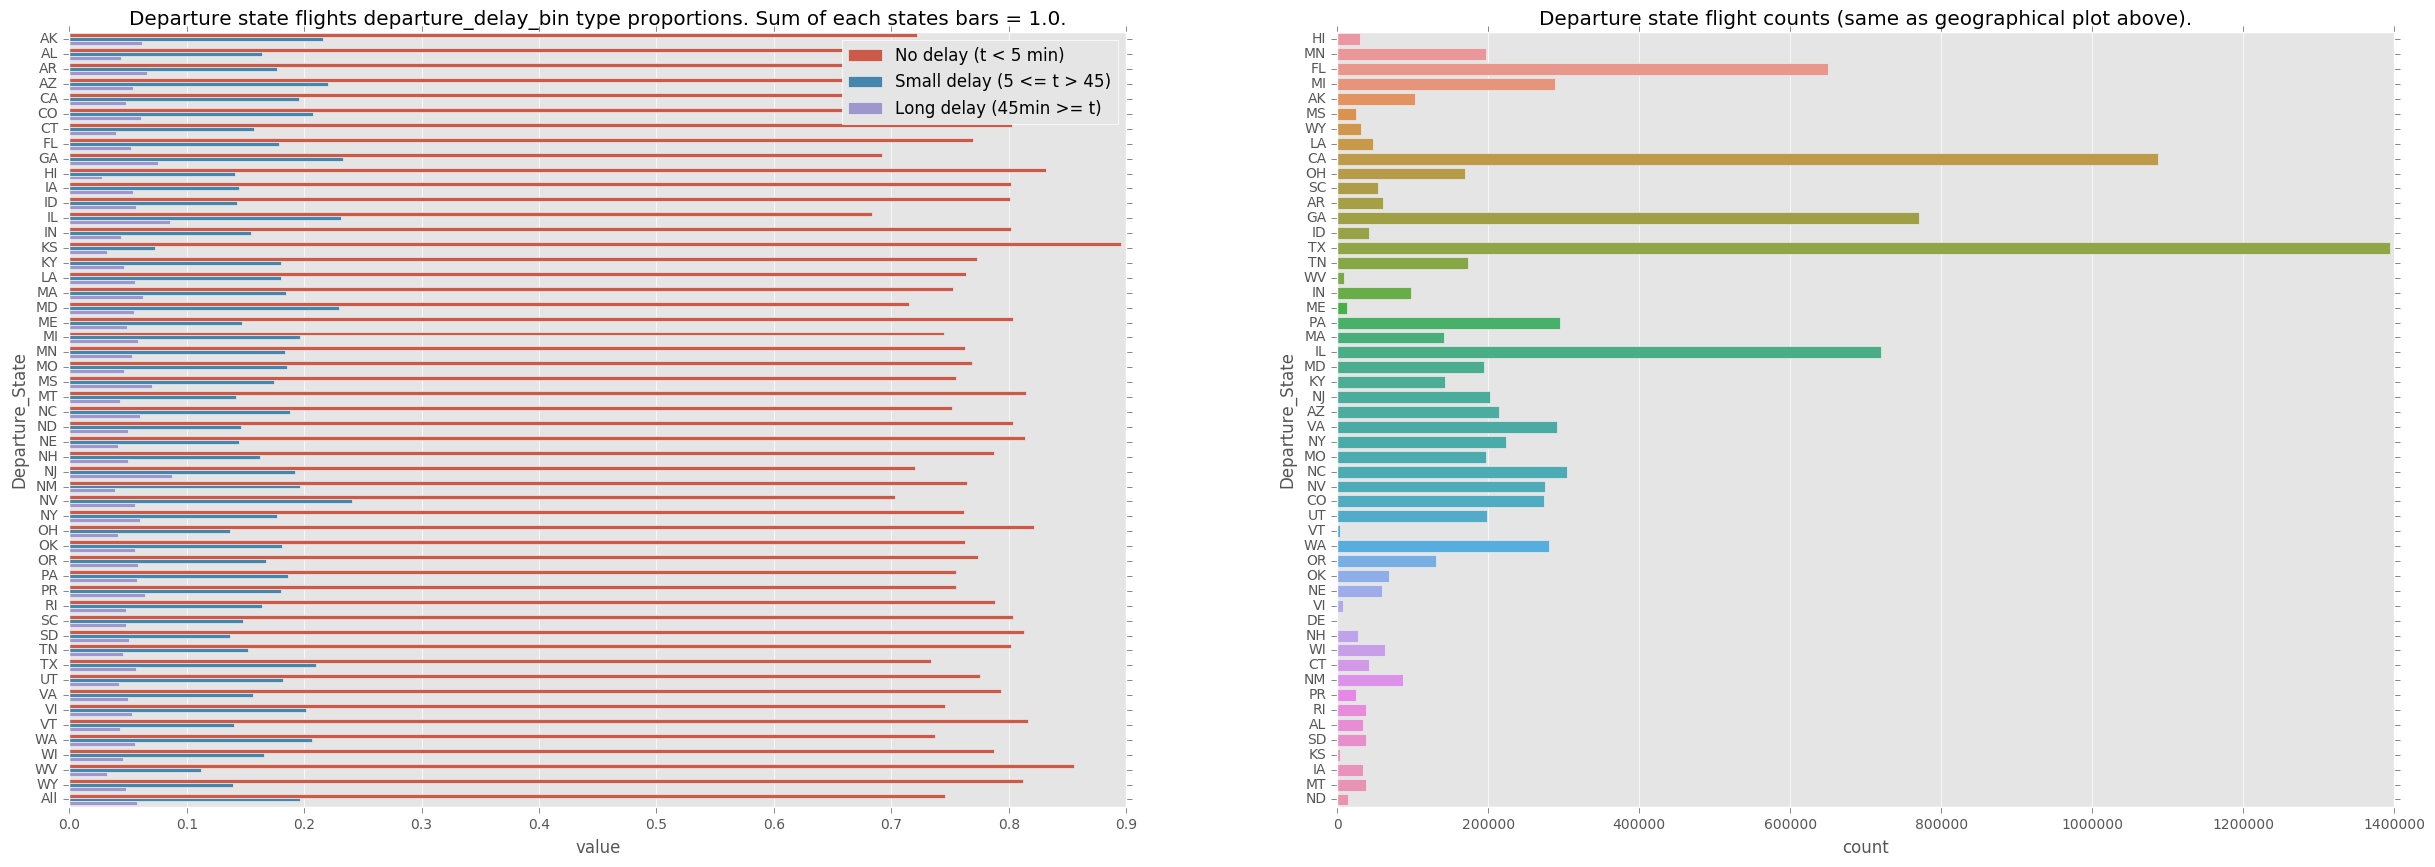

In [17]:
delays_state = pd.crosstab(flights['Departure_State'],flights['Departure_delay_bin'],margins=True)
delays_state = delays_state[delays_state.All>1000] # consider states who have had at least 1000 flights
delays_state.drop('All',axis=1,inplace=True)
delays_state_prop = delays_state.div(delays_state.sum(axis=1), axis=0)
delays_state_prop_stack = delays_state_prop.stack().reset_index().rename(columns={0:'value'}) # for sns

f, (ax1,ax2) = plt.subplots(1, 2,figsize=(30,10))
sns.countplot(y='Departure_State',data=flights,ax=ax2)
sns.barplot(y=delays_state_prop_stack.Departure_State, x=delays_state_prop_stack.value,
            hue=delays_state_prop_stack.Departure_delay_bin,ax=ax1);
ax1.set_title("Departure state flights departure_delay_bin type proportions. Sum of each states bars = 1.0.")
ax2.set_title("Departure state flight counts (same as geographical plot above).")
L = ax1.legend()
L.get_texts()[0].set_text('No delay (t < 5 min)')
L.get_texts()[1].set_text('Small delay (5 <= t > 45)')
L.get_texts()[2].set_text('Long delay (45min >= t)')
plt.show()

### Delays arguably related to weather which is related to location. Should see relationship between latitude ("north-south") and delay time

Departure_delay_bin  No delay  Small delay  Long delay
latitude_bin                                          
north                 2324119       593991      195130
south                 5058073      1350829      377881
Departure_delay_bin  No delay  Small delay  Long delay
latitude_bin                                          
north                0.746527     0.190795    0.062677
south                0.745283     0.199038    0.055679

 P value = 0.000000. reject independence


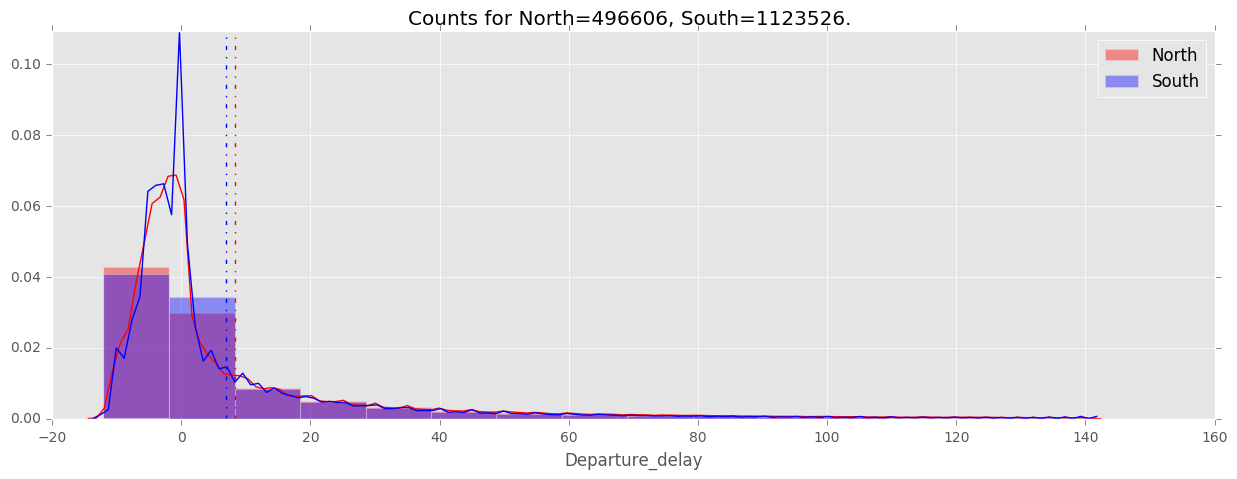

In [18]:
flights['latitude_bin'] = np.where(flights.Latitude>40,'north','south') # anything above 40 lat classes as north
Lat_contingency = Cross_tab(flights['latitude_bin'],flights['Departure_delay_bin'])
Lat_contingency.chi2_test()
flights_winter = flights[flights['month'].isin([1,12])] # winter months
north_delays_winter = flights_winter[(flights_winter['latitude_bin']=='north')]['Departure_delay']
south_delays_winter = flights_winter[(flights_winter['latitude_bin']=='south')]['Departure_delay']
dist1={'values':north_delays_winter,'name':'North'}
dist2={'values':south_delays_winter,'name':'South'}
plot_two_dist(dist1,dist2)

* some difference in continous departure delays. possibly need specific weather information.
* From cross-table - north flights have a higher proportion of long delays - possibly due to weather???

## <center>Focus on one airline and its most popular airport for time being</center>

In [19]:
airline = 'US'
airline_flights = flights.drop(flights[flights.Airline != airline].index)
airport = airline_flights.Departure_Airport.value_counts().argmax()
airline_flights = airline_flights.drop(airline_flights[airline_flights.Departure_Airport != airport].index)
print("Number of samples = {0} for airline == {1} and airport = {2}.".format(airline_flights.shape[0],airline,airport))

Number of samples = 83304 for airline == US and airport = PIT.


### Make a 'busy' variable which looks back at the last few days and counts the number of flights that occured in that period. Hopefully an indicator for delays.

In [45]:
def busy(df,row,n_days_look_back = 1):
    look_back_date = row['Date'] + pd.DateOffset(-n_days_look_back)
    after_look_back = (df.Date >= look_back_date)
    before_current = (df.Date <= row['Date'])
    busy = (after_look_back & before_current).sum() # number of flights in last n_days_look_back days
    return busy
airline_flights['Busy'] = airline_flights.apply(lambda row: busy(airline_flights,row),axis=1)

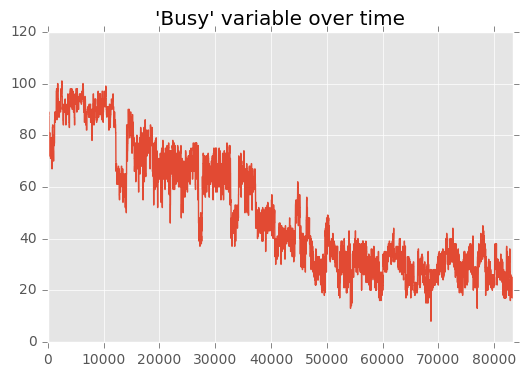

In [46]:
airline_flights.sort_values("Date",inplace=True) # for plot
airline_flights.reset_index(drop=True,inplace=True)
airline_flights.Busy.plot()
plt.title("'Busy' variable over time")
plt.show()

### Load weather data

In [22]:
weather = pd.read_csv("weather.csv")
weather["Date"] = pd.to_datetime(weather["Date"])
weather = weather.rename(columns={"airport": "Departure_Airport"})

* If snow and rain do not change (i.e. std==0) by day at each airport then we can just merge our flight data and weather data and keep any one of the time values. 
* Obviously it would be better if we had real time data as opposed to daily.

In [23]:
weather_by_date_airport = weather[['snow','wind',"Date","Departure_Airport"]].groupby(["Date","Departure_Airport"]).agg(['std'])
np.any(weather_by_date_airport>0) # snow and rain values do not change each day given an airport.
weather.drop('time',axis=1,inplace=True) # therefore time is redundant
weather.drop_duplicates(inplace=True) 

Merge airline data with weather

In [24]:
airline_flights_weather = airline_flights.merge(weather,how='left',on=["Date","Departure_Airport"], indicator=True) # merge with flight data.

For snow and wind assume null = 0. i.e. no entry has been entered into dataset if no snow or wind.

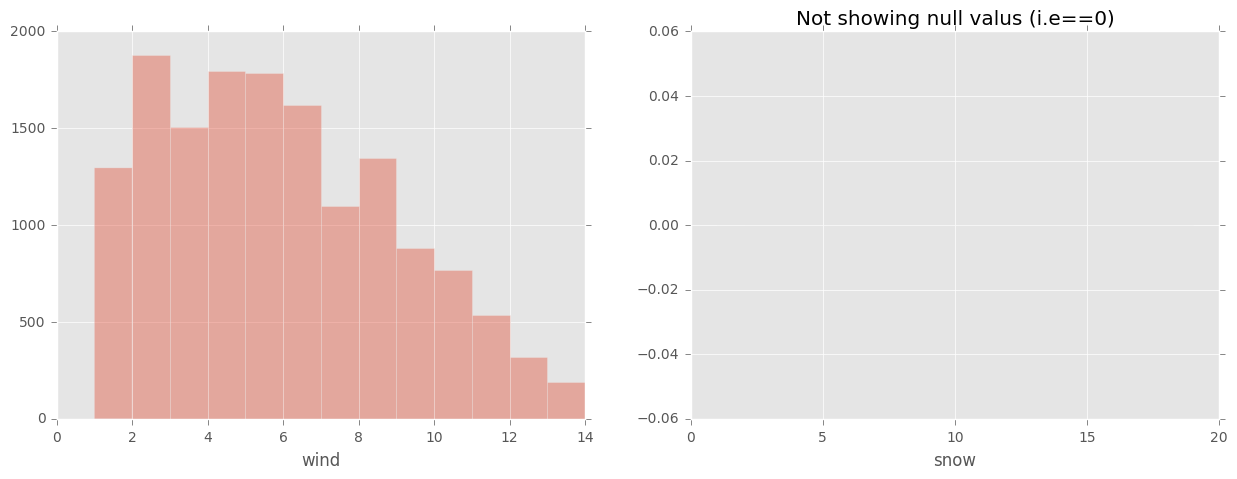

In [25]:
airline_flights_weather[['snow','wind']] = airline_flights_weather[['snow','wind']].fillna(0)
f, (ax1,ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
plt.title("Not showing null valus (i.e==0)")
sns.distplot(airline_flights_weather.wind,bins=np.arange(1,15,1),ax=ax1,label='wind',kde=False)
sns.distplot(airline_flights_weather.snow,bins=np.arange(1,20,1),ax=ax2,label='snow',kde=False)
plt.show()

* Incredibly sparse variables, best to bin

### Check delay distribution by whether or not snow was present.


 Snow bool threshold = 1
Departure_delay_bin  Long delay  No delay  Small delay
snow_bool                                             
False                      3215     67345        12744
Departure_delay_bin  Long delay  No delay  Small delay
snow_bool                                             
False                  0.038594  0.808425     0.152982

 P value = 1.000000. accept null of independence


/Users/matt/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6016: RuntimeWarning:

invalid value encountered in true_divide



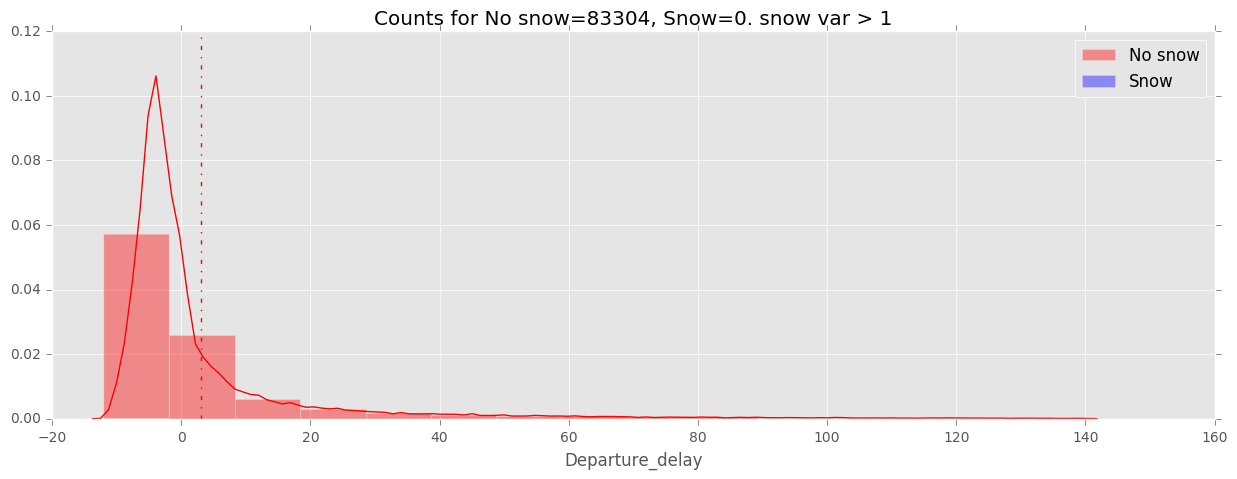

In [26]:
snow_value = 1
print("\n Snow bool threshold = {0}".format(snow_value))
airline_flights_weather['snow_bool'] = airline_flights_weather[['snow']] > snow_value
snow_contingency = Cross_tab(airline_flights_weather['snow_bool'],airline_flights_weather['Departure_delay_bin'])
snow_contingency.chi2_test()

def snow_plot(): # no point with this airport
    no_snow = airline_flights_weather['Departure_delay'][airline_flights_weather.snow_bool==0]
    snow = airline_flights_weather['Departure_delay'][airline_flights_weather.snow_bool==1]
    dist1={'values':no_snow,'name':'No snow'}
    dist2={'values':snow,'name':'Snow'}
    title = 'snow var > {0}'.format(snow_value)
    plot_two_dist(dist1,dist2,title_append=title)

* No snow amounts in this airport.

### Do the same but with wind.

Wind threshold = 10
Departure_delay_bin  Long delay  No delay  Small delay
wind_bool                                             
False                      3112     65767        12235
True                        103      1578          509
Departure_delay_bin  Long delay  No delay  Small delay
wind_bool                                             
False                  0.038366  0.810797     0.150837
True                   0.047032  0.720548     0.232420

 P value = 0.000000. reject independence


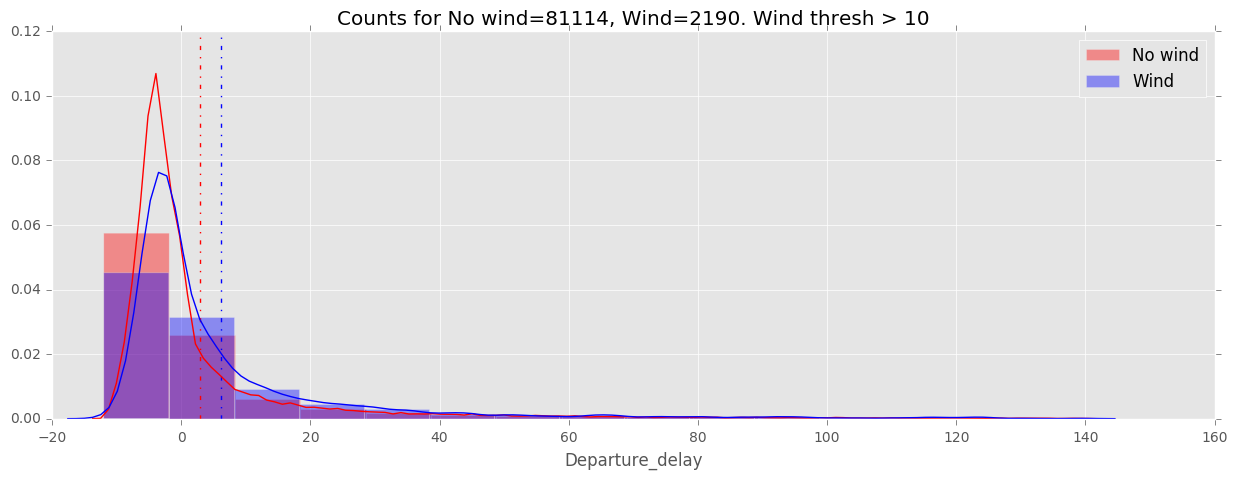

In [27]:
wind_value = 10 # strong?
print("Wind threshold = " + str(wind_value))
airline_flights_weather['wind_bool'] = airline_flights_weather['wind'] > wind_value
snow_contingency = Cross_tab(airline_flights_weather['wind_bool'],airline_flights_weather['Departure_delay_bin'])
snow_contingency.chi2_test()

no_wind = airline_flights_weather['Departure_delay'][airline_flights_weather.wind_bool==0]
wind = airline_flights_weather['Departure_delay'][airline_flights_weather.wind_bool==1]
dist1={'values':no_wind,'name':'No wind'}
dist2={'values':wind,'name':'Wind'}
title = 'Wind thresh > {0}'.format(wind_value)
plot_two_dist(dist1,dist2,title_append=title)

* Wind seems to have made an impact on delays.
* Our choice of wind threshold is fairly arbitrary and could possible be done better with something like chi merge.

### Ice or no ice (sub zero). Assume mean temperature for missing

In [28]:
airline_flights_weather.temperature.fillna(airline_flights_weather.temperature.mean(),inplace=True)
print("Mean temperature = {0:.2f}".format(airline_flights_weather['temperature'].mean()))

Mean temperature = 51.31


* Must be in farenheit

Departure_delay_bin  Long delay  No delay  Small delay
sub_zero                                              
False                      3088     65199        12103
True                        127      2146          641
Departure_delay_bin  Long delay  No delay  Small delay
sub_zero                                              
False                  0.038413  0.811034     0.150554
True                   0.043583  0.736445     0.219973

 P value = 0.000000. reject independence


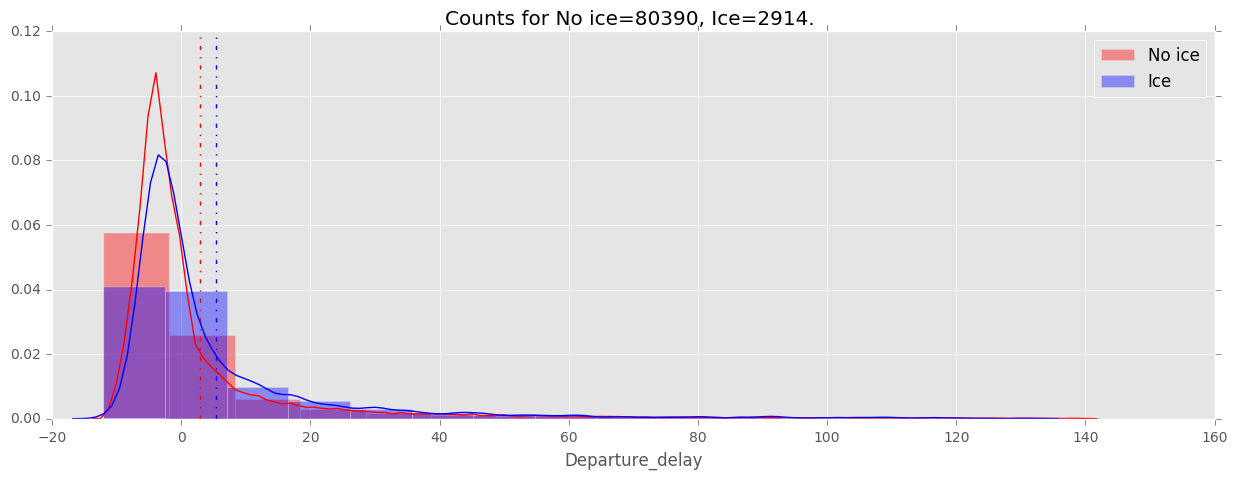

In [29]:
airline_flights_weather['sub_zero'] = airline_flights_weather['temperature'] < 32 #0C = 32F
snow_contingency = Cross_tab(airline_flights_weather['sub_zero'],airline_flights_weather['Departure_delay_bin'])
snow_contingency.chi2_test()

no_ice = airline_flights_weather['Departure_delay'][airline_flights_weather.sub_zero==False] ## may not be actual ice, just a name.
ice = airline_flights_weather['Departure_delay'][airline_flights_weather.sub_zero==True]
dist1={'values':no_ice,'name':'No ice'}
dist2={'values':ice,'name':'Ice'}
plot_two_dist(dist1,dist2)

* "Ice" is quite rare event but looks like it increases delays
* Accept null of independence at 1%, just.

### Time of day and delays

* Clean 'Departure_schedule' to datetime object

In [30]:
def add_0(time): # function to add zeros to Departure_schedule
    if len(time) == 1:
        return '000' + time
    elif len(time) == 2:
        return '00' + time
    elif len(time) == 3:
        return '0'+time
    else:
        return time
    
airline_flights_weather['Departure_schedule'] = airline_flights_weather['Departure_schedule'].astype(int) # in case float
airline_flights_weather['Departure_schedule'] = airline_flights_weather['Departure_schedule'].astype(str)
airline_flights_weather['Departure_schedule_add0'] = airline_flights_weather['Departure_schedule'].apply(add_0)
airline_flights_weather['Departure_schedule_hour'] = pd.to_datetime(airline_flights_weather['Departure_schedule_add0'],
                                                                    format='%H%M').dt.hour
airline_flights_weather['Time_of_day'] = pd.cut(airline_flights_weather['Departure_schedule_hour'],
                                        np.arange(0,30,6),right=False,
                                        labels=['Early morning','Morning','Afternoon','Evening'])
airline_flights_weather[['Departure_schedule','Departure_schedule_hour','Time_of_day']].sample(5) # example

,Departure_schedule,Departure_schedule_hour,Time_of_day
46202,1750,17,Afternoon
81520,850,8,Morning
63571,1730,17,Afternoon
68045,2035,20,Evening
4445,1215,12,Afternoon


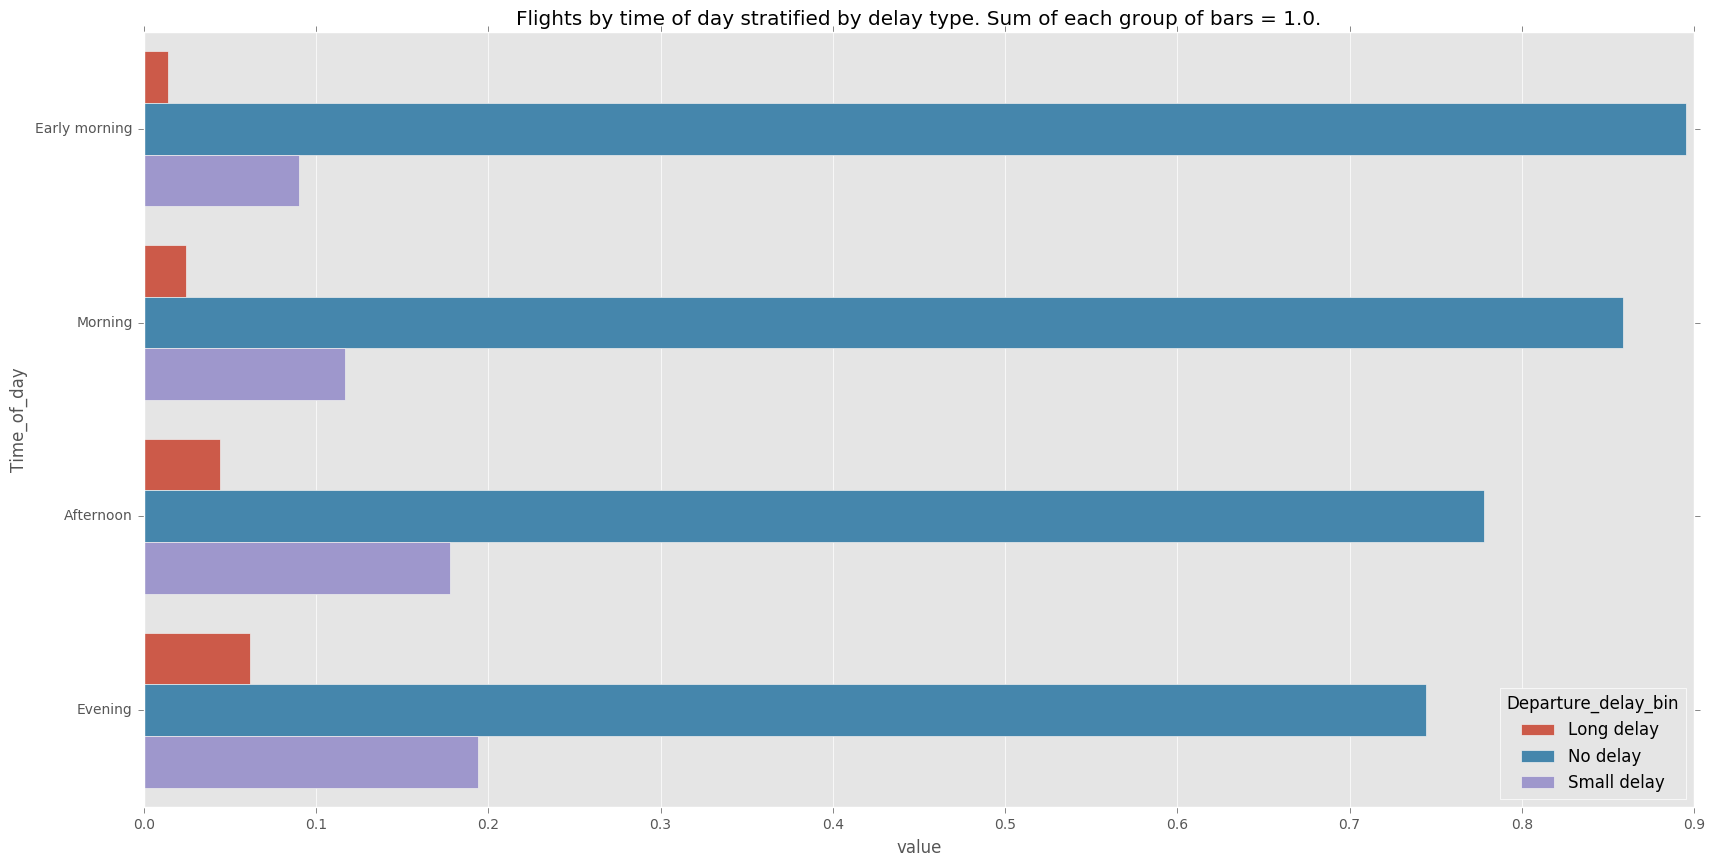

In [31]:
Time_of_day_delays = Cross_tab(airline_flights_weather['Time_of_day'],airline_flights_weather['Departure_delay_bin'])
time_of_day_delays = Time_of_day_delays.cross_tab
time_of_day_delays_prop = time_of_day_delays.div(time_of_day_delays.sum(axis=1), axis=0)
time_of_day_delays_prop_stack = time_of_day_delays_prop.stack().reset_index().rename(columns={0:'value'}) # for sns

f, ax1 = plt.subplots(1, 1,figsize=(20,10))
sns.barplot(y=time_of_day_delays_prop_stack.Time_of_day, x=time_of_day_delays_prop_stack.value,
            hue=time_of_day_delays_prop_stack.Departure_delay_bin,ax=ax1);
ax1.set_title("Flights by time of day stratified by delay type. Sum of each group of bars = 1.0.")
plt.show()

* Evening flights have high proportion of delays

# <center> Delay times - model example/framework</center>

## Try to predict our ```Departure_delay_bin``` variable



In [32]:
from sklearn.cross_validation import StratifiedShuffleSplit as SSS
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import log_loss
import numpy.random as rng

/Users/matt/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [49]:
def train(X,Y,random_forest_params):
    X = pd.get_dummies(X)
    
    le = LE()
    Y = le.fit_transform(Y)
    sss = SSS(y=Y,n_iter=1,test_size=0.2,random_state=1006)
    for tr_idx, te_idx in sss:
        X_tr, X_te = X.ix[tr_idx], X.ix[te_idx]
        Y_tr, Y_te = Y[tr_idx], Y[te_idx]
    print("Train and test sizes are {0} and {1}".format(X_tr.shape,X_te.shape))

    rf = RF(n_estimators=random_forest_params['n_estimators'],
           max_leaf_nodes=random_forest_params['max_leaf_nodes'],
            max_depth=random_forest_params['max_depth']
           )

    rf.fit(X_tr,Y_tr)

    guess = (pd.Series(Y_tr).value_counts().sort_index()/Y_tr.shape).as_matrix() # guess equal to proportions 
    guesses = np.tile(guess,Y_te.size).reshape(Y_te.size,3)
    Y_tr_pred = rf.predict_proba(X_tr)
    Y_te_pred = rf.predict_proba(X_te)

    log_loss_tr = log_loss(y_true = Y_tr, y_pred = Y_tr_pred)
    log_loss_te = log_loss(y_true = Y_te, y_pred = Y_te_pred)
    log_loss_to_beat = log_loss(y_true = Y_te, y_pred = guesses)

    print("Train error = {0:.4f}. Test error = {1:.4f}. log_loss_to_beat = {2:.4f}.\n".format(log_loss_tr,log_loss_te,log_loss_to_beat))

    print("Feature importances")
    for feat,feat_import in zip(X.columns,rf.feature_importances_):
        print("{0} has importance of {1:.4f}.".format(feat,feat_import))

# Hyperparams

In [50]:
random_forest_params = {
    'n_estimators': 50,
    'max_leaf_nodes': 1000,
    'max_depth': None
}

snow_value = 1
wind_value = 15
ice = 32
XY = airline_flights_weather.copy()

XY['Time_of_day'] = pd.cut(XY['Departure_schedule_hour'],
                                        np.array([0,12,18,24]),right=False,
                                        labels=['Morning','Afternoon','Evening'])

XY['snow_bool'] = XY[['snow']] > snow_value
XY['wind_bool'] = XY['wind'] > wind_value
XY['sub_zero'] = XY['temperature'] < ice #0C = 32F

x_keep = ['month','Time_of_day','Busy','wind_bool']
X = XY[x_keep]
Y = airline_flights_weather["Departure_delay_bin"]

train(X,Y,random_forest_params)

Train and test sizes are (66643, 6) and (16661, 6)
Train error = 0.5285. Test error = 0.5684. log_loss_to_beat = 0.5848.

Feature importances
month has importance of 0.2170.
Busy has importance of 0.6444.
wind_bool has importance of 0.0117.
Time_of_day_Morning has importance of 0.0746.
Time_of_day_Afternoon has importance of 0.0224.
Time_of_day_Evening has importance of 0.0298.
